# Hacker Statistics
by: Paul Jeffries

This code was adapted in large part from this DataCamp course in the Python Data Scientist track, but was inspired mostly by [Jake Vanderplas' excellent PyCon 2016 talk--Statistics for Hackers](https://www.youtube.com/watch?v=Iq9DzN6mvYA). In his talk, which I highly recommend to anyone not familiar with what is meant by "hacker statistics," Jake dives into the "four recipes for hacking statistics":

Note: All of these methods assume independent and identically distributed data, and sometimes dependence can be really subtle--so be careful with this!

1. Direct Simulation
    - Great if we have an *a priori* understanding of the underlying generating model for the data and we can similuate that process end-to-end (like checking to see if a coin is a fair coin).
2. Shuffling
    - Great if we don't have an understanding of the underlying generating model for the data and we want to compare one group to another group (like checking differences in test scores between two groups). 
3. Bootsrapping
    - Also great if we don't have an understanding of the underlying generating model for the data and we want to better understand some statistic for a population (like trying to establish a confidence interval around a mean).
    - Works poorly with low sample sizes (N > 20 as good rule of thumb) or with cases where the target statistic is rank-based (like maximum value). 
4. Cross Validation
    - Most often used with machine learning & model-building because it's useful for cases/models where you can't really examine / compare the statistical distribution of the results. 


In [1]:
import datetime
print('Last Updated On: ', datetime.datetime.today().strftime('%Y-%m-%d'))

Last Updated On:  2018-11-22


In [2]:
# key packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# basic setup steps

# prints the present working directory (helpful for sourcing the CSVs later)
%pwd

# setting seed for any functions that require randomization (for repeatability)
np.random.seed(123)

## Bootstrap Sampling and Bootstrap Replicates

In [4]:
# import the dataset from csv into a pandas df
# specify that there are NAs in the data that take the value '?'
projects_df = pd.read_csv('data/auto-mpg.csv', na_values='?')

# print the head of the df to inspect what we imported
print(projects_df.head())

    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model year  origin                   car name  
0          70       1  chevrolet chevelle malibu  
1          70       1          buick skylark 320  
2          70       1         plymouth satellite  
3          70       1              amc rebel sst  
4          70       1                ford torino  


In [5]:
# now we'll go beyond a visual spot check to examine the df
print(projects_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      392 non-null float64
weight          398 non-null int64
acceleration    398 non-null float64
model year      398 non-null int64
origin          398 non-null int64
car name        398 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB
None


In [6]:
# it looks from the initial df.info() that 'horsepower' has 6 NULLs, so we'll clean those up
# we'll subset the df to the columns we care about, drop NAs, and inspect
projects_df = projects_df.loc[:,['mpg','horsepower']].dropna()
print(projects_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 2 columns):
mpg           392 non-null float64
horsepower    392 non-null float64
dtypes: float64(2)
memory usage: 9.2 KB
None


In [7]:
# now it looks like we've cleaned up all the nulls; our df is clean and gtg

# we'll pick just two columns--'mpg' and 'horsepower'--for our bootstrapping
# breaking them out into separate Pandas series will help us out later 
mpg_cleaned = projects_df['mpg']
horsepower_cleaned = projects_df['horsepower']

In [8]:
# before boostrapping, we should do some quick data quality checks
print("The total number of observations in this data is:", len(mpg_cleaned))
print("There are a total of", (len(mpg_cleaned) - len(mpg_cleaned.dropna())), "nulls in mpg_cleaned.")

print("The total number of observations in this data is:", len(horsepower_cleaned))
print("There are a total of", (len(horsepower_cleaned) - len(horsepower_cleaned.dropna())), "nulls in for horsepower_cleaned.")
# in this case we're good to proceed with our analysis

The total number of observations in this data is: 392
There are a total of 0 nulls in mpg_cleaned.
The total number of observations in this data is: 392
There are a total of 0 nulls in for horsepower_cleaned.


### Single Variable Boostrapping (1-Dimension)

In [9]:
def bootstrap_replicate_1d(data,func,n_obs_to_sample=100):
    """Generate boostrap replicate of 1-Dimension data given
    a series, a function for which to retrieve a replicate (for
    example np.mean), and the number of observations to sample."""
    
    # randomly draw numb_obs_to_sample observations (with replacement) from data
    bs_sample = np.random.choice(data, size=n_obs_to_sample, replace=True)
    
    # returns the result of the function chosen applied tothe sampled observations
    return func(bs_sample)

In [10]:
def draw_bs_reps(data, func, n_obs_to_sample, n_reps_to_draw=1):
    """Draw n_reps_to_draw bootstrap replicates using boostrap_replicate_1d."""

    # initialize empty array to store replicates: bs_replicates
    bs_replicates = np.empty(n_reps_to_draw)

    # generate and store i replicates
    for i in range(n_reps_to_draw):
        bs_replicates[i] = bootstrap_replicate_1d(data, func, n_obs_to_sample)

    # returns numpy array of all boostrap replicates drawn
    return bs_replicates

In [11]:
# take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(
    data = mpg_cleaned, 
    func = np.mean, 
    n_obs_to_sample=len(mpg_cleaned), 
    n_reps_to_draw=10_000)

# compute and print the standard error of the mean (SEM)
sem = np.std(mpg_cleaned) / np.sqrt(len(mpg_cleaned))
print("The standard error of the mean (SEM) of mpg_cleand is:", sem)

# compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print("The standard deviation of the boostrap replicates drawn is:", bs_std)

The standard error of the mean (SEM) of mpg_cleand is: 0.39370926560373704
The standard deviation of the boostrap replicates drawn is: 0.394762542881384


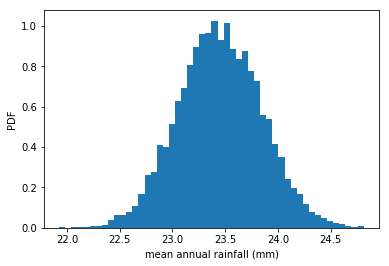

In [12]:
# make a histogram of the results of the bs replicates for the mean of mpg_cleaned
_ = plt.hist(bs_replicates, bins=50, density=True)
_ = plt.xlabel('mean annual rainfall (mm)')
_ = plt.ylabel('PDF')

# show the plot
plt.show()

In [13]:
# get the confidence bands based on our boostrapped replicates
# the percentiles below amount to our confidence interval bounds
conf_int = np.percentile(bs_replicates,[2.5,97.5])

# now we can print the confidence interval, with bounds rounded to nearest tenth
print("The 95% confidence interval is between", conf_int[0].round(1), "and", conf_int[1].round(1),"mpg.")

The 95% confidence interval is between 22.7 and 24.2 mpg.


### Pairs Boostrapping (2-Dimensions)

This is broadly similar to the methodology expounded above for drawing bootsrap replicates from 1-dimensional data, except now we'll extend this to work with pairs of data points.

In [14]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # set up array of indices to sample from: inds
    # because we're drawing from paired columns, we need to sample using the index
    inds = np.arange(len(x))

    # initialize placeholders for replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # generate replicates
    for i in range(size):
        # randomly sample indexes (w/ replacement) 
        bs_inds = np.random.choice(inds, size=len(inds), replace=True)
        # use the randomly selected index to draw boostrap samples of x and y
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        # use the bs samples to calculate bs reps for slope and intercept of linreg line
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(x = bs_x, y=bs_y, deg=1)
    
    # return the slope and intercept boostrap replicates
    return bs_slope_reps, bs_intercept_reps

In [15]:
# generate 1000 replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(
    x = mpg_cleaned.values, 
    y = horsepower_cleaned.values, 
    size=1000)

The 95% CI for the slope is between -4.2 and -3.5 mpg.


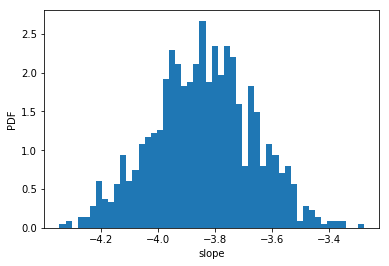

In [16]:
# compute and print 95% CI for the slope
slope_confint = np.percentile(bs_slope_reps, [2.5, 97.5])
print("The 95% CI for the slope is between", slope_confint[0].round(1), "and", slope_confint[1].round(1),"mpg.")

# plot the histogram of the bs reps for slope
_ = plt.hist(bs_slope_reps, bins=50, density=True)
_ = plt.xlabel('slope')
_ = plt.ylabel('PDF')
plt.show()

The 95% CI for the intercept is between 185.4 and 204.0 mpg.


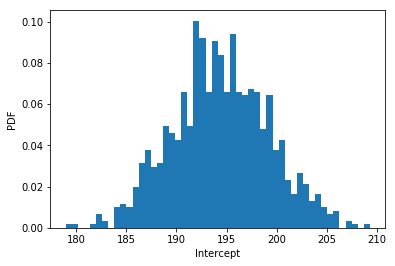

In [17]:
# compute and print 95% CI for the intercept of the regression line
interc_confint = np.percentile(bs_intercept_reps, [2.5, 97.5])
print("The 95% CI for the intercept is between", interc_confint[0].round(1), "and", interc_confint[1].round(1),"mpg.")

# plot the histogram of the bs reps for intercept
_ = plt.hist(bs_intercept_reps, bins=50, density=True)
_ = plt.xlabel('Intercept')
_ = plt.ylabel('PDF')
plt.show()

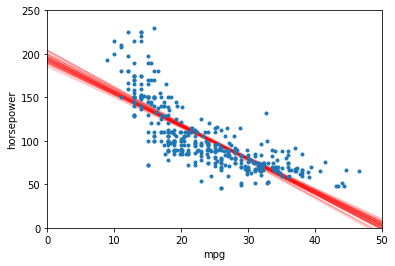

In [18]:
# generate array of x-values for bootstrap lines: x
x = np.array([0, 100])

# plot the lines that result from the bootstrap slope and intercept replicates
for i in range(100):
    _ = plt.plot(x,                               
                 bs_slope_reps[i] * x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='red')

# plot the raw data points
_ = plt.plot(mpg_cleaned.values, horsepower_cleaned.values, marker='.', linestyle='none')

# label axes, set the margins, and show the plot
_ = plt.xlabel('mpg')
_ = plt.ylabel('horsepower')
_ = plt.xlim(0, 50)
_ = plt.ylim(0, 250)
plt.show()